<a href="https://colab.research.google.com/github/martintmv-git/photogrammetry/blob/main/Experiments/Stockpile%20volume%20computation/Stockpile_volume_computation_Open3D_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stockpile volume computation with Open3D - Google Colab Env Experiment
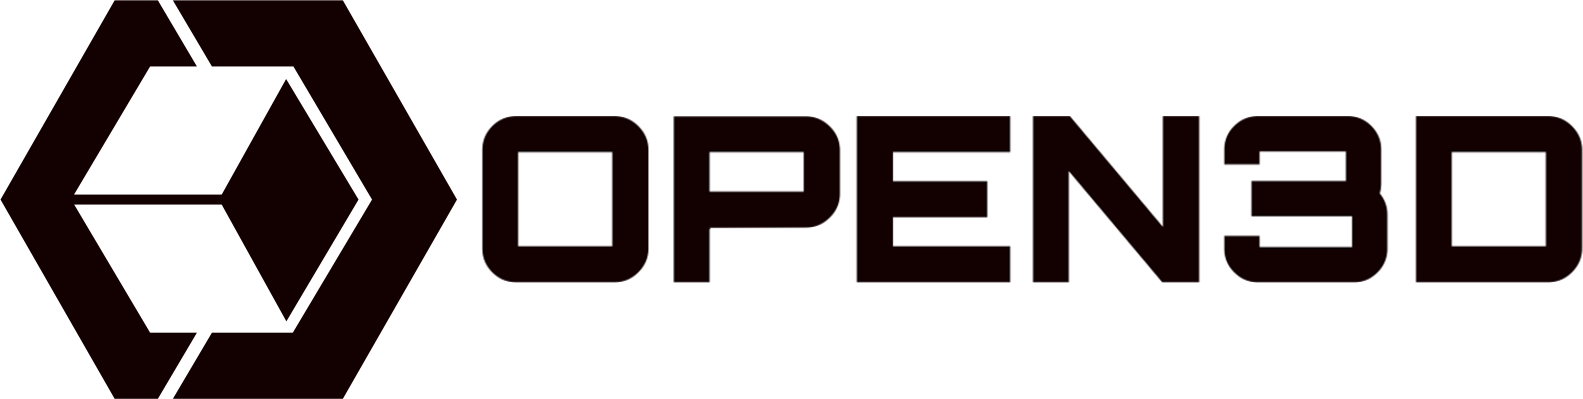

## Cell 1: Install Necessary Packages
This cell will handle the installation of necessary Python packages in Colab environment.

In [ ]:
# Install necessary libraries
!pip install open3d pythreejs

In [2]:
# Check installed versions of pythreejs and ipywidgets
!pip show pythreejs ipywidgets

Name: pythreejs
Version: 2.4.2
Summary: Interactive 3D graphics for the Jupyter Notebook and JupyterLab, using Three.js and Jupyter Widgets.
Home-page: https://github.com/jupyter-widgets/pythreejs
Author: PyThreejs Development Team
Author-email: jason@jasongrout.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: ipydatawidgets, ipywidgets, numpy, traitlets
Required-by: 
---
Name: ipywidgets
Version: 8.1.2
Summary: Jupyter interactive widgets
Home-page: http://jupyter.org
Author: Jupyter Development Team
Author-email: jupyter@googlegroups.com
License: BSD 3-Clause License
Location: /usr/local/lib/python3.10/dist-packages
Requires: comm, ipython, jupyterlab-widgets, traitlets, widgetsnbextension
Required-by: bigframes, bqplot, cufflinks, ipydatawidgets, ipyevents, ipyfilechooser, ipyleaflet, ipytree, open3d, pythreejs


In [3]:
# Import general libraries
from google.colab import drive
import numpy as np
import open3d as o3d
import math
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from functools import reduce

# Specific imports for interactive 3D visualization
from pythreejs import Mesh, MeshStandardMaterial, BufferGeometry, BufferAttribute, PerspectiveCamera, Scene, AmbientLight, DirectionalLight, Renderer, OrbitControls

## Cell 2: Mount Google Drive
This cell is for mounting Google Drive to access the dataset.

In [4]:
# Mount Google Drive to access the dataset
drive.mount('/content/drive')

Mounted at /content/drive


## Cell 3: Define Functions for 3D Visualization
Define the functions necessary to convert Open3D geometries to `pythreejs` objects for visualization.

In [11]:
def setup_scene(*meshes):
    # Create lights
    directional_light = DirectionalLight(color='white', position=[3, 5, 1], intensity=0.5)
    ambient_light = AmbientLight(intensity=0.5)

    # Create scene
    scene = Scene(children=list(meshes) + [directional_light, ambient_light])

    # Set up camera
    camera = PerspectiveCamera(position=[3, 3, 3], fov=75)

    # Render the scene
    renderer = Renderer(camera=camera, scene=scene, controls=[OrbitControls(controlling=camera)], background='black', width=800, height=600)
    return renderer

In [6]:
def o3d_geometry_to_pythreejs_mesh(geometry, color):
    if isinstance(geometry, o3d.geometry.PointCloud):
        # Handle PointCloud objects
        vertices = np.asarray(geometry.points)
        if np.asarray(geometry.colors).size == 0:
            # Apply uniform color if no colors are specified
            colors = np.tile(color, (len(vertices), 1))
        else:
            colors = np.asarray(geometry.colors)
    elif isinstance(geometry, o3d.geometry.TriangleMesh):
        # Handle TriangleMesh objects
        vertices = np.asarray(geometry.vertices)
        if np.asarray(geometry.vertex_colors).size == 0:
            colors = np.tile(color, (len(vertices), 1))
        else:
            colors = np.asarray(geometry.vertex_colors)

    # Create buffer geometry
    buffer_geometry = BufferGeometry(attributes={
        'position': BufferAttribute(vertices.astype(np.float32), normalized=False),
        'color': BufferAttribute(colors.astype(np.float32), normalized=True)
    })

    # Create material
    material = MeshStandardMaterial(vertexColors='VertexColors', side='DoubleSide')

    # Create mesh
    mesh = Mesh(geometry=buffer_geometry, material=material)
    return mesh

## Cell 4: Read and Process the Point Cloud Data
Process the point cloud data, applies transformations, and prepares the objects for visualization.

In [7]:
# Pop-up Colab support
from google.colab import output
output.enable_custom_widget_manager()

In [13]:
# Load point cloud
pcd = o3d.io.read_point_cloud("/content/drive/MyDrive/photogrammetry/stockpile.ply")
axes = o3d.geometry.TriangleMesh.create_coordinate_frame()

# Segment the plane
plane_model, inliers = pcd.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=10000)
plane_pcd = pcd.select_by_index(inliers)
plane_pcd.paint_uniform_color([1.0, 0, 0])
stockpile_pcd = pcd.select_by_index(inliers, invert=True)
stockpile_pcd.paint_uniform_color([0, 0, 1.0])

# Prepare meshes for visualization
plane_mesh = o3d_geometry_to_pythreejs_mesh(plane_pcd, [1.0, 0, 0])
stockpile_mesh = o3d_geometry_to_pythreejs_mesh(stockpile_pcd, [0, 0, 1.0])
axes_mesh = o3d_geometry_to_pythreejs_mesh(axes, [0.5, 0.5, 0.5])

# Setup and display the scene
scene = setup_scene(plane_mesh, stockpile_mesh, axes_mesh)
display(scene)

Renderer(camera=PerspectiveCamera(fov=75.0, position=(3.0, 3.0, 3.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.…

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_1789a981-c98d-49f4-b0be-effd4d5923c1'.

## Cell 5: Compute the volume of the stockpile

In [15]:
# Compute the volume of the stockpile
def get_triangles_vertices(triangles, vertices):
    triangles_vertices = []
    for triangle in triangles:
        new_triangles_vertices = [vertices[triangle[0]], vertices[triangle[1]], vertices[triangle[2]]]
        triangles_vertices.append(new_triangles_vertices)
    return np.array(triangles_vertices)

def volume_under_triangle(triangle):
    p1, p2, p3 = triangle
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    x3, y3, z3 = p3
    return abs((z1+z2+z3) * (x1*y2 - x2*y1 + x2*y3 - x3*y2 + x3*y1 - x1*y3) / 6)

downpdc = stockpile_pcd.voxel_down_sample(voxel_size=0.05)
xyz = np.asarray(downpdc.points)
xy_catalog = np.array([[point[0], point[1]] for point in xyz])
tri = Delaunay(xy_catalog)

# Create a TriangleMesh using the vertices and the triangles from Delaunay triangulation
surface = o3d.geometry.TriangleMesh()
surface.vertices = o3d.utility.Vector3dVector(xyz)
surface.triangles = o3d.utility.Vector3iVector(tri.simplices)
surface.paint_uniform_color([0, 0, 1.0])

# Compute the volume
triangles_vertices = get_triangles_vertices(surface.triangles, surface.vertices)
volume = reduce(lambda a, b: a + volume_under_triangle(b), triangles_vertices, 0)

# Output the volume
print(f"The volume of the stockpile is: {round(volume, 2)} cubic meters")

The volume of the stockpile is: 0.29 cubic meters
